In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train = True,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train = False,download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=4, shuffle=False, num_workers=2)

classes = ('plane','car','bird','deer','dog','frog','horse','ship','truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


horse  carplaneplane


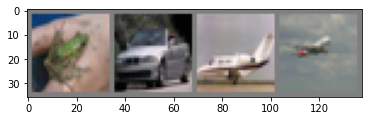

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img /2 +0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))

dataiter = iter(trainloader)
images,labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(''.join('%5s' %classes[labels[j]] for j in range(4)))


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16*5*5,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1,16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.001,momentum = 0.9)

for epoch in range(10):
  running_loss = 0.0
  for i, data in enumerate(trainloader,0):
    inputs,labels = data
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i% 2000 == 1999:
      print('[%d, %5d] loss : %.3f' %(epoch+1,i +1, running_loss/2000))
print('Finish Training')

[1,  2000] loss : 2.283
[1,  4000] loss : 4.276
[1,  6000] loss : 6.011
[1,  8000] loss : 7.631
[1, 10000] loss : 9.184
[1, 12000] loss : 10.687
[2,  2000] loss : 1.428
[2,  4000] loss : 2.839
[2,  6000] loss : 4.192
[2,  8000] loss : 5.516
[2, 10000] loss : 6.819
[2, 12000] loss : 8.115
[3,  2000] loss : 1.243
[3,  4000] loss : 2.454
[3,  6000] loss : 3.645
[3,  8000] loss : 4.840
[3, 10000] loss : 6.031
[3, 12000] loss : 7.212
[4,  2000] loss : 1.100
[4,  4000] loss : 2.198
[4,  6000] loss : 3.325
[4,  8000] loss : 4.449
[4, 10000] loss : 5.562
[4, 12000] loss : 6.646
[5,  2000] loss : 1.016
[5,  4000] loss : 2.046
[5,  6000] loss : 3.102
[5,  8000] loss : 4.159
[5, 10000] loss : 5.208
[5, 12000] loss : 6.244
[6,  2000] loss : 0.975
[6,  4000] loss : 1.963
[6,  6000] loss : 2.943
[6,  8000] loss : 3.922
[6, 10000] loss : 4.922
[6, 12000] loss : 5.915
[7,  2000] loss : 0.900
[7,  4000] loss : 1.825
[7,  6000] loss : 2.782
[7,  8000] loss : 3.732
[7, 10000] loss : 4.693
[7, 12000] loss

In [2]:
# ResNet을 전이 학습

from __future__ import print_function,division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models,transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])      
    ]),
    'val': transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])  
                               ]),
}
data_dir = '/content/drive/My Drive/hymenoptera_data/hymenoptera_data'
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle = True,
                                             num_workers=4) for x in ['train','val']}
dataset_sizes = { x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


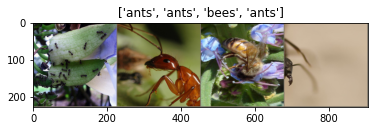

In [4]:
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])
  inp = std * inp +mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(000.1)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer,scheduler, num_epochs = 25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch,num_epochs - 1))
    print('-'*10)
    for phase in ['train','val']:
      if phase == 'train':
        scheduler.step()
        model.train()
      else :
        model.eval()
      running_loss = 0.0
      running_corrects = 0
      for inputs,labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      epoch_loss = running_loss/ dataset_sizes[phase]
      epoch_acc = running_corrects.double()/ dataset_sizes[phase]
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,epoch_acc))
      if phase == 'val' and epoch_acc > best_acc:
        best_acc  = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print()
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed //60,time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))
  model.load_state_dict(best_model_wts)
  return model

        


In [6]:
def visualize_model(model, num_images =6):
  was_traing = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _,preds = torch.max(outputs,1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2,2,images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode = was_traing)
          return
      
    #model.train(mode == was_traing)
    model.train(model == was_traing)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.6799 Acc: 0.6762
val Loss: 0.2405 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4935 Acc: 0.7746
val Loss: 0.2923 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.5073 Acc: 0.8238
val Loss: 0.4458 Acc: 0.8301

Epoch 3/24
----------
train Loss: 0.4359 Acc: 0.8156
val Loss: 0.2342 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.5132 Acc: 0.8033
val Loss: 0.3954 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.3693 Acc: 0.8402
val Loss: 0.3753 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.4578 Acc: 0.8074
val Loss: 0.2941 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.3666 Acc: 0.8443
val Loss: 0.3038 Acc: 0.8693

Epoch 8/24
----------
train Loss: 0.3533 Acc: 0.8484
val Loss: 0.2571 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3294 Acc: 0.8443
val Loss: 0.2362 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2915 Acc: 0.8689
val Loss: 0.2413 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3305 Acc: 0.8525
val Loss: 0.2297 Acc: 0.9150

Epoch 12/24
----------
t

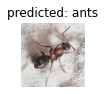

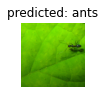

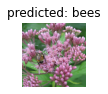

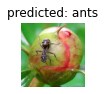

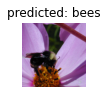

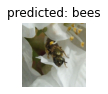

In [ ]:
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)
model_ft = train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,num_epochs = 25)

visualize_model(model_ft)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.5497 Acc: 0.6721
val Loss: 0.2433 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4791 Acc: 0.7582
val Loss: 0.1774 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.4813 Acc: 0.7787
val Loss: 0.1819 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.5971 Acc: 0.7664
val Loss: 0.2353 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.4970 Acc: 0.8115
val Loss: 0.1806 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3194 Acc: 0.8525
val Loss: 0.2870 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.3392 Acc: 0.8484
val Loss: 0.1427 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3659 Acc: 0.8402
val Loss: 0.1525 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3444 Acc: 0.8648
val Loss: 0.1467 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.4278 Acc: 0.7828
val Loss: 0.1953 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3950 Acc: 0.7992
val Loss: 0.1821 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.4148 Acc: 0.7992
val Loss: 0.1739 Acc: 0.9477

Epoch 12/24
----------
t

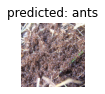

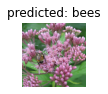

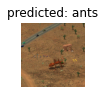

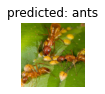

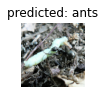

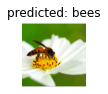

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma = 0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler,num_epochs=25)
visualize_model(model_conv)

plt.ioff()
plt.show()